# Exercice 5 : Visualisation des représentations internes des réseaux de neurones


In [5]:
from keras.datasets import mnist
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import ConvexHull
from sklearn.mixture import *
from scipy import linalg
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_yaml

In [2]:
def convexHulls(points, labels):
  # computing convex hulls for a set of points with asscoiated labels
  convex_hulls = []
  for i in range(10):
    convex_hulls.append(ConvexHull(points[labels==i,:]))
  return convex_hulls
def best_ellipses(points, labels):
  # computing best fiiting ellipse for a set of points with asscoiated labels
  gaussians = []
  for i in range(10):
    gaussians.append(GaussianMixture(n_components=1, covariance_type='full').fit(points[labels==i, :]))
  return gaussians

def neighboring_hit(points, labels):
  k = 6
  nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(points)
  distances, indices = nbrs.kneighbors(points)

  txs = 0.0
  txsc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  nppts = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

  for i in range(len(points)):
    tx = 0.0
    for j in range(1,k+1):
      if (labels[indices[i,j]]== labels[i]):
        tx += 1
        tx /= k
        txsc[labels[i]] += tx
        nppts[labels[i]] += 1
        txs += tx

  for i in range(10):
    txsc[i] /= nppts[i]

  return txs / len(points)

def visualization(points2D, labels, convex_hulls, ellipses ,projname, nh):

  points2D_c= []
  for i in range(10):
      points2D_c.append(points2D[labels==i, :])
  # Data Visualization
  cmap =cm.tab10

  plt.figure(figsize=(3.841, 7.195), dpi=100)
  plt.set_cmap(cmap)
  plt.subplots_adjust(hspace=0.4 )
  plt.subplot(311)
  plt.scatter(points2D[:,0], points2D[:,1], c=labels,  s=3,edgecolors='none', cmap=cmap, alpha=1.0)
  plt.colorbar(ticks=range(10))

  plt.title("2D "+projname+" - NH="+str(nh*100.0))

  vals = [ i/10.0 for i in range(10)]
  sp2 = plt.subplot(312)
  for i in range(10):
      ch = np.append(convex_hulls[i].vertices,convex_hulls[i].vertices[0])
      sp2.plot(points2D_c[i][ch, 0], points2D_c[i][ch, 1], '-',label='$%i$'%i, color=cmap(vals[i]))
  plt.colorbar(ticks=range(10))
  plt.title(projname+" Convex Hulls")

  def plot_results(X, Y_, means, covariances, index, title, color):
      splot = plt.subplot(3, 1, 3)
      for i, (mean, covar) in enumerate(zip(means, covariances)):
          v, w = linalg.eigh(covar)
          v = 2. * np.sqrt(2.) * np.sqrt(v)
          u = w[0] / linalg.norm(w[0])
          # as the DP will not use every component it has access to
          # unless it needs it, we shouldn't plot the redundant
          # components.
          if not np.any(Y_ == i):
              continue
          plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color, alpha = 0.2)

          # Plot an ellipse to show the Gaussian component
          angle = np.arctan(u[1] / u[0])
          angle = 180. * angle / np.pi  # convert to degrees
          ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
          ell.set_clip_box(splot.bbox)
          ell.set_alpha(0.6)
          splot.add_artist(ell)

      plt.title(title)
  plt.subplot(313)

  for i in range(10):
      plot_results(points2D[labels==i, :], ellipses[i].predict(points2D[labels==i, :]), ellipses[i].means_,
      ellipses[i].covariances_, 0,projname+" fitting ellipses", cmap(vals[i]))

  plt.savefig(projname+".png", dpi=100)
  plt.show()

def loadModel(savename):
 with open(savename+".yaml", "r") as yaml_file:
  model = model_from_yaml(yaml_file.read())
 print( "Yaml Model ",savename,".yaml loaded ")
 model.load_weights(savename+".h5")
 print( "Weights ",savename,".h5 loaded ")
 return model

In [3]:
from keras.datasets import mnist
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [6]:
# LOADING MODEL
nameModel = "my_model_MLP" #REPLACE WITH YOUR MODEL NAME
model = loadModel(nameModel)
model.summary()



Yaml Model  my_model_MLP .yaml loaded 







C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\keras\engine\saving.py:473: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)



Weights  my_model_MLP .h5 loaded 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc2 (Dense)                  (None, 100)               78500     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
fc3 (Dense)                  (None, 10)                1010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [7]:
# convert class vectors to binary class matrices
Y_test = np_utils.to_categorical(y_test, 10)
# COMPILING MODEL
learning_rate = 1.0
sgd = SGD(learning_rate)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

scores_test = model.evaluate(X_test, Y_test, verbose=1)
print("PERFS TEST: %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))



10000/10000 [==============================] - 1s 83us/step
PERFS TEST: acc: 98.03%


In [8]:
#On évalue les performances du modèle chargé sur la base de test de MNIST pour vérifier son comportement.

model.pop() #permettant de supprimer la couche au sommet du modèle
#On vas l'appliquer deux fois (on supprime la couche d’activation softmax et la couche complètement connectée)

model.summary()
model.pop()
model.summary()
predict = model.predict(X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc2 (Dense)                  (None, 100)               78500     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
fc3 (Dense)                  (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc2 (Dense)                  (None, 100)               78500     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
__

C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [9]:
#Ensuite on va utiliser la méthode t-SNE mise en place à l’exercice 2 pour visualiser les représentations internes des données.

X_embedded = TSNE(n_components=2, perplexity=30.0, init='pca', verbose=2).fit_transform(predict)
#[t-SNE] Error after 1000 iterations: 1.328868
#X_embedded_PCA = PCA(n_components=2, svd_solver='full').fit_transform(X_train_5000)
# Function Call
convex_hulls= convexHulls(X_embedded, y_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.141s...
[t-SNE] Computed neighbors for 10000 samples in 59.580s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.867681
[t-SNE] Computed conditional probabilities in 0.880s
[t-SNE] Iteration 50: error = 79.8826828, gradient norm = 0.0027431 (50 iterations in 16.770s)
[t-SNE] 

In [10]:
# Function Call
ellipses = best_ellipses(X_embedded, y_test)
nh= neighboring_hit(X_embedded, y_test)

C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same ar

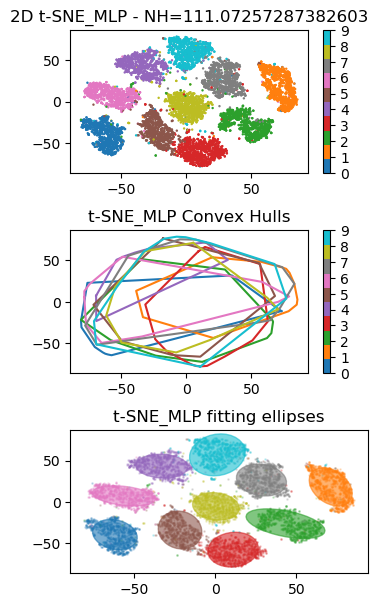

In [11]:
visualization(X_embedded, y_test, convex_hulls, ellipses ,'t-SNE_MLP', nh)

In [12]:
##Pour le model ConvNet my_model_ConvNet
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

60000 train samples
10000 test samples


In [13]:
# LOADING MODEL
nomModel = "my_model_ConvNet"
model = loadModel(nomModel)
model.summary()

C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\keras\engine\saving.py:473: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


Yaml Model  my_model_ConvNet .yaml loaded 
Weights  my_model_ConvNet .h5 loaded 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
fc4 (Dense)                  (None, 100)               25700     
_____________________________________________________________

In [14]:
# convert class vectors to binary class matrices
Y_test = np_utils.to_categorical(y_test, 10)
# COMPILING MODEL
learning_rate = 1.0
sgd = SGD(learning_rate)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])


In [15]:
scores_test = model.evaluate(X_test, Y_test, verbose=1)
print("PERFS TEST: %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))
#On évalue les performances du modèle chargé sur la base de test de MNIST pour vérifier son comportement.

model.pop() #permettant de supprimer la couche au sommet du modèle
#On vas l'appliquer deux fois (on supprime la couche d’activation softmax et la couche complètement connectée)
model.summary()
model.pop()
model.summary()
predict = model.predict(X_test)

10000/10000 [==============================] - 11s 1ms/step
PERFS TEST: acc: 99.12%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
fc4 (Dense)                  (None, 100)               25700     
__________________________________________________________

C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [16]:
#Ensuite on va utiliser la méthode t-SNE mise en place à l’exercice 2 pour visualiser 
#les représentations internes des données.
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [17]:
X_embedded = TSNE(n_components=2, perplexity=30.0, init='pca', verbose=2).fit_transform(predict)
# Function Call
convex_hulls= convexHulls(X_embedded, y_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.223s...
[t-SNE] Computed neighbors for 10000 samples in 80.710s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.876252
[t-SNE] Computed conditional probabilities in 1.635s
[t-SNE] Iteration 50: error = 74.7496109, gradient norm = 0.0039611 (50 iterations in 16.921s)
[t-SNE] 

In [18]:
# Function Call
ellipses = best_ellipses(X_embedded, y_test)
nh= neighboring_hit(X_embedded, y_test)

C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\utilisateur\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same ar

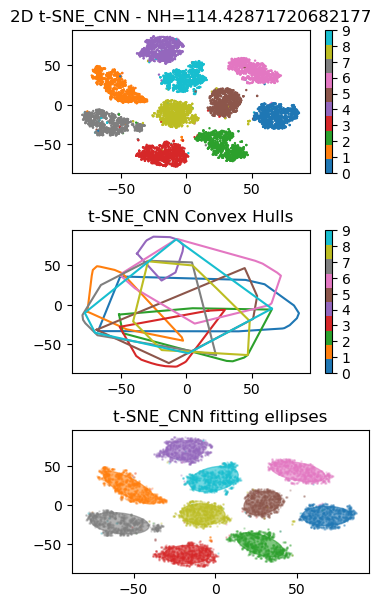

In [19]:
visualization(X_embedded, y_test, convex_hulls, ellipses ,'t-SNE_CNN', nh)